In [43]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint



In [44]:
def load_dataset(filename):
    df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
    print(df.head())
    intent = df["Intent"]
    unique_intent = list(set(intent))
    sentences = list(df["Sentence"])
  
    return (intent, unique_intent, sentences)
  


In [45]:
intent, unique_intent, sentences = load_dataset("data.csv")

                   Sentence  Intent
0              Order please   order
1      Ship this item to me   order
2  Can I order that please?   order
3        Where is the help?  common
4           Purchase <Item>   order


In [46]:
print(sentences[35])
print(unique_intent)


Are you out of <item>?
['balance', 'order', 'price', 'common']


In [47]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxlengdell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxlengdell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:
#define stemmer
stemmer = LancasterStemmer()

In [49]:
def cleaning(sentences):
    words = []
    for s in sentences:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    
    return words  

In [50]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  
  


237
[['order', 'please'], ['ship', 'this', 'item', 'to', 'me']]


In [51]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    print(token)
    return token

In [52]:
def max_length(words):
    return(len(max(words, key = len)))
  

In [53]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 144 and Maximum length = 9


In [54]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [55]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)
#print(encoded_doc)

In [56]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [57]:
padded_doc = padding_doc(encoded_doc, max_length)

In [58]:
padded_doc[:5]

array([[12, 28,  0,  0,  0,  0,  0,  0,  0],
       [97,  7,  1, 21,  9,  0,  0,  0,  0],
       [25,  2, 12, 46, 28,  0,  0,  0,  0],
       [55,  3, 13, 31,  0,  0,  0,  0,  0],
       [33,  1,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

In [59]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (237, 9)


In [60]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [61]:
output_tokenizer.word_index

{'balance': 1, 'order': 2, 'price': 3, 'common': 4}

In [62]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [63]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [64]:
encoded_output.shape

(237, 1)

In [65]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [66]:
output_one_hot = one_hot(encoded_output)

In [67]:
output_one_hot.shape

(237, 4)

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)


In [70]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (189, 9) and train_Y = (189, 4)
Shape of val_X = (48, 9) and val_Y = (48, 4)


In [71]:
def create_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = True))
    model.add(Bidirectional(LSTM(128)))
#   model.add(LSTM(128))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = "softmax"))
  
    return model





In [72]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 9, 128)            18432     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 132       
Total params: 289,956
Trainable params: 289,956
Non-trainable params: 0
_________________________________________________________________


In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(train_X, train_Y, epochs = 200, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Train on 189 samples, validate on 48 samples
Epoch 1/200
189/189 [==============================] - 4s 22ms/step - loss: 0.0570 - accuracy: 0.9947 - val_loss: 0.4457 - val_accuracy: 0.9167

Epoch 00001: val_loss improved from inf to 0.44574, saving model to model.h5
Epoch 2/200
189/189 [==============================] - 0s 1ms/step - loss: 0.0792 - accuracy: 0.9788 - val_loss: 0.4713 - val_accuracy: 0.9167

Epoch 00002: val_loss did not improve from 0.44574
Epoch 3/200
189/189 [==============================] - 0s 1ms/step - loss: 0.0576 - accuracy: 0.9841 - val_loss: 0.4422 - val_accuracy: 0.9375

Epoch 00003: val_loss improved from 0.44574 to 0.44223, saving model to model.h5
Epoch 4/200
189/189 [==============================] - 0s 1ms/step - loss: 0.1603 - accuracy: 0.9683 - val_loss: 0.3216 - val_accuracy: 0.9375

Epoch 00004: val_loss improved from 0.44223 to 0.32164, saving model to model.h5
Epoch 5/200
189/189 [==============================] - 0s 1ms/step - loss: 0.0513 - accu

189/189 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.9017 - val_accuracy: 0.8958

Epoch 00042: val_loss did not improve from 0.24012
Epoch 43/200
189/189 [==============================] - 0s 1ms/step - loss: 0.0129 - accuracy: 0.9894 - val_loss: 0.9142 - val_accuracy: 0.8958

Epoch 00043: val_loss did not improve from 0.24012
Epoch 44/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.9947 - val_loss: 0.9060 - val_accuracy: 0.8958

Epoch 00044: val_loss did not improve from 0.24012
Epoch 45/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.9947 - val_loss: 0.9064 - val_accuracy: 0.8958

Epoch 00045: val_loss did not improve from 0.24012
Epoch 46/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9947 - val_loss: 0.9080 - val_accuracy: 0.8958

Epoch 00046: val_loss did not improve from 0.24012
Epoch 47/200
189/189 [===========

189/189 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9894 - val_loss: 0.9850 - val_accuracy: 0.9167

Epoch 00084: val_loss did not improve from 0.24012
Epoch 85/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.9962 - val_accuracy: 0.9167

Epoch 00085: val_loss did not improve from 0.24012
Epoch 86/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 0.9947 - val_loss: 0.9916 - val_accuracy: 0.9167

Epoch 00086: val_loss did not improve from 0.24012
Epoch 87/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.9946 - val_accuracy: 0.9167

Epoch 00087: val_loss did not improve from 0.24012
Epoch 88/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9894 - val_loss: 1.0118 - val_accuracy: 0.9167

Epoch 00088: val_loss did not improve from 0.24012
Epoch 89/200
189/189 [===========


Epoch 00125: val_loss did not improve from 0.24012
Epoch 126/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.5145 - val_accuracy: 0.8958

Epoch 00126: val_loss did not improve from 0.24012
Epoch 127/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9947 - val_loss: 1.5562 - val_accuracy: 0.8958

Epoch 00127: val_loss did not improve from 0.24012
Epoch 128/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0216 - accuracy: 0.9841 - val_loss: 1.6385 - val_accuracy: 0.8750

Epoch 00128: val_loss did not improve from 0.24012
Epoch 129/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.6583 - val_accuracy: 0.8750

Epoch 00129: val_loss did not improve from 0.24012
Epoch 130/200
189/189 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9947 - val_loss: 1.6051 - val_accuracy: 0.8958

Epoch 00130: v

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


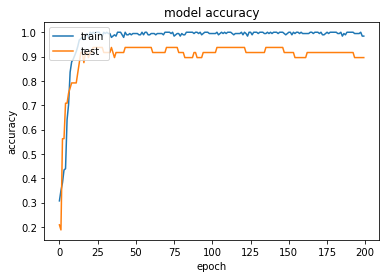

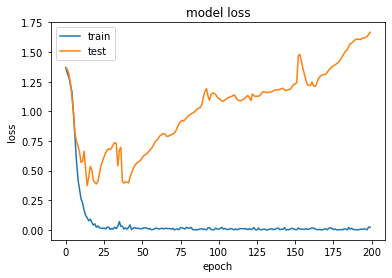

In [74]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
 model = load_model("model.h5")

/Users/maxlengdell/opt/anaconda3/envs/nnD7046E/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [76]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    print(test_word)
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
    x = padding_doc(test_ls, max_length)
  
    pred = model.predict_proba(x)
  
  
    return pred


  

In [77]:
def get_final_output(pred, classes):
    predictions = pred[0]
 
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
 
    for i in range(pred.shape[1]):
        print("%s has confidence = %s" % (classes[i], (predictions[i])))



In [78]:
#Price
text = "How much does it cost?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['how', 'much', 'does', 'it', 'cost']
price has confidence = 0.99968886
balance has confidence = 0.0003107582
order has confidence = 2.9935424e-07
common has confidence = 2.0552145e-08


In [79]:
#Balance
text = "how many pants are in stock?"
pred = predictions(text)
get_final_output(pred, unique_intent)

['how', 'many', 'pants', 'are', 'in', 'stock']
balance has confidence = 0.99999905
price has confidence = 7.4048245e-07
order has confidence = 1.5461433e-07
common has confidence = 4.7497267e-08


In [80]:
#Order
text = "I want to buy 3 pants"
pred = predictions(text)
get_final_output(pred, unique_intent)

['i', 'want', 'to', 'buy', '3', 'pants']
order has confidence = 0.99681735
common has confidence = 0.0028340167
price has confidence = 0.00020716395
balance has confidence = 0.00014147996


In [81]:
#Common
text = "I need help"
pred = predictions(text)
get_final_output(pred, unique_intent)

['i', 'need', 'help']
order has confidence = 0.84783244
common has confidence = 0.13630454
price has confidence = 0.0087884525
balance has confidence = 0.0070746485


In [280]:
opening_lines = ['Hello, what can I help you with?',
                'How can I help you?',
                'Whats on your mind today?']

def randomOpening():
    index = random.randint(0,len(opening_lines)-1)
    print(opening_lines[index])



In [ ]:
def cli():
    while True:
        randomOpening()
        user_input = input("Ask the chatbot something: ")
        print(user_input)
        if(user_input=="quit"):
            break
        else:
            pred = predictions(user_input)
            print(pred)
            get_final_output(pred, unique_intent)

        
cli()

Hello, what can I help you with?
